In [1]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from abc import ABCMeta, abstractmethod

from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
data = SynthDataset(x_dim=2, N=500, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

## Analyzing

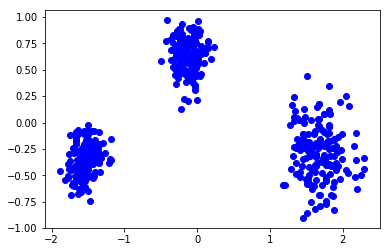

In [3]:
x = data.X.numpy()
x_r, x_f = pca(x, x)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')

## BGAN

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, x_dim, num_samples=1):
        super(GeneratorNetwork, self).__init__()
        self.build_net(x_dim, num_samples)
        self.output_dim = x_dim
    
    def build_net(self, x_dim, num_samples):
        z = torch.from_numpy(np.random.normal(size=[num_samples, x_dim])).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        # TODO: understand parallelism?
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.x_dim = x_dim
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        # TODO: understand parallelism?
        output = self.network(input)
        return output

In [7]:
class FixedSizeDataset(torch.utils.data.Dataset):
    
    def __init__(self, maxlen):
        self.elems = []
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        return self.elems[index]
    
    def append(self, elem):
        self.elems.append(elem)
        if len(self) > self.maxlen:
            self.elems = self.elems[1:]
    
    def __len__(self):
        return len(self.elems)

In [95]:
class BGAN:
    
    def __init__(self, generator, generator_prior, discriminator, num_data, eta=2e-4, alpha=0.01, max_fake=10000,
                disc_lr=1e-3):
        """
        Bayesian GAN with no generator
        """
        super(BGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        
        self.x_dim = discriminator.x_dim
        self.eta = eta
        self.alpha = alpha
        self.num_data = num_data
        self.disc_lr = disc_lr
        self.generator_prior = generator_prior
            
        self.K = discriminator.K
        self._init_optimizers()
        self.fake_dataset = FixedSizeDataset(max_fake)
        self.fake_dataset.append(np.copy(self.generator.forward().data.numpy())[0, :])
        self.fake_batch_loader = torch.utils.data.DataLoader(self.fake_dataset, 
                                                            batch_size=64, shuffle=True)
        self.fake_batch_generator = self.get_fake_batch()
        
    def get_fake_batch(self):
        while True:
            for batch in self.fake_batch_loader:
                yield Variable(batch.float())
            
    def loss(self, x_batch):
        batch_size = x_batch.size()[0]
        fake_batch = next(self.fake_batch_generator)
        x_gen = self.generator.forward()
        x_real = x_batch
        
        
        d_logits_real = self.discriminator(x_real)[:, 0]
        d_logits_fake = self.discriminator(fake_batch)[:, 0]
        d_logits_gen = self.discriminator(x_gen)[:, 0]
        
        y_real = Variable(torch.ones(batch_size))
        y_fake = Variable(torch.zeros(fake_batch.size()[0]))
        y_gen = Variable(torch.zeros(x_gen.size()[0]))
        
        bce = nn.BCELoss()
        bce_real = bce(d_logits_real, y_real)
        bce_fake = bce(d_logits_fake, y_fake)
        bce_gen = bce(d_logits_gen, y_gen)
        noise_std = np.sqrt(2 * self.alpha * self.eta)
        
        d_loss = -(bce_real + bce_fake) * self.disc_lr
        d_loss *= -1.
        
        #generator loss
        g_loss = torch.sum(torch.log(d_logits_gen[0])) * self.eta
        g_loss -= torch.sum(1 - torch.log(d_logits_gen[0])) * self.eta
        g_loss += self.noise(self.generator, noise_std)
        g_loss += (self.generator_prior.log_density(self.generator)
                      * self.eta)
        g_loss *= -1.
        self.d_loss_fake = (bce_fake).data.numpy()[0]
        self.d_loss_real = bce_real.data.numpy()[0]
        return d_loss, g_loss
        
    @staticmethod
    def noise(model, std):
        """
        Multiplies all the variables by a normal rv for SGHMC.
        """
        loss = 0
        for param in model.parameters():
            n = Variable(torch.normal(0, std=std*torch.ones(param.size())))
            loss += torch.sum(n * param)
        return loss
    
    def _init_optimizers(self):
        self.d_optimizer = optim.SGD(self.discriminator.parameters(), lr=1, momentum=(1 - self.alpha))
        self.g_optimizer = optim.SGD(self.generator.parameters(), lr=1, momentum=(1 - self.alpha))
        
    
    def step(self, x_batch):
        
        batchv = Variable(batch)
        self.discriminator.zero_grad()
        self.generator.zero_grad()
        d_loss, g_loss = self.loss(batchv)
        d_loss.backward(retain_graph=True)
        self.d_optimizer.step()
        
        g_loss.backward()
        self.g_optimizer.step()     
        

In [96]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [97]:
prior = FactorizedNormalPrior(std=5.)
gen = GeneratorNetwork(2, 5)
disc = DiscriminatorNetwork(2, 2, 100)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, prior, disc, alpha=.01, eta=1e-6, num_data=len(data), disc_lr=1e-4)
samples = []

In [98]:
def flatten(samples):
    flat_samples = []
    for k in range(samples.shape[1]):
        flat_samples.append(samples[:, k, :])
    flat_samples = np.vstack(flat_samples)
    return flat_samples

def visualize(samples, x_min=None, x_max=None, y_min=None, y_max=None, with_samples=True, n_grid=500):
    
    flat_samples = flatten(samples)
    min_samples = np.array((np.min(flat_samples[:, 0]), np.min(flat_samples[:, 1])))
    max_samples = np.array((np.max(flat_samples[:, 0]), np.max(flat_samples[:, 1])))
    min_x = np.array((np.min(x[:, 0]), np.min(x[:, 1])))
    max_x = np.array((np.max(x[:, 0]), np.max(x[:, 1])))
    min_ = np.min(np.vstack([min_samples[None, :], min_x[None, :]]), axis=0)
    max_ = np.max(np.vstack([max_samples[None, :], max_x[None, :]]), axis=0)
#     print(min_, max_)
#     print(np.hstack([max_samples[None, :], max_x[None, :]]))
    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    
    probs = disc.forward(Variable(torch.from_numpy(w_grid).float())).data.numpy()
    plt.figure(figsize=(15, 10))
    CS = plt.contour(w_grid_x, w_grid_y, (probs[:, 0]).reshape((n_grid, n_grid)))
#     print(w_grid_x)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Simplest default with labels')
    plt.plot(x[:, 0], x[:, 1], 'o', alpha=0.1)
    if with_samples:
        for k in range(samples.shape[1]):
            plt.plot(samples[:, k, 0], samples[:, k, 1], '-')
            plt.plot(samples[-1, k, 0], samples[-1, k, 1], 'o', markersize=10)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

In [109]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(1500):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        cur_samples = np.copy(gen.z_v.data.numpy())
        for sample in cur_samples:
            bgan.fake_dataset.append(sample)
        
        samples.append(cur_samples.tolist())
        
    if not epoch%100:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
samples = np.array(samples)

0
0.14394
0.0666421
100
0.0881542
0.0477417
200
0.122493
0.0901098
300
0.087385
0.0892224
400
0.0907352
0.148319
500
0.146186
0.129375
600
0.136355
0.248582
700
0.136259
0.137356
800
0.186037
0.183101
900
0.0987174
0.180671
1000
0.113281
0.188924
1100
0.142772
0.192242
1200
0.111306
0.212668
1300
0.018514
0.141346
1400
0.130408
0.108468


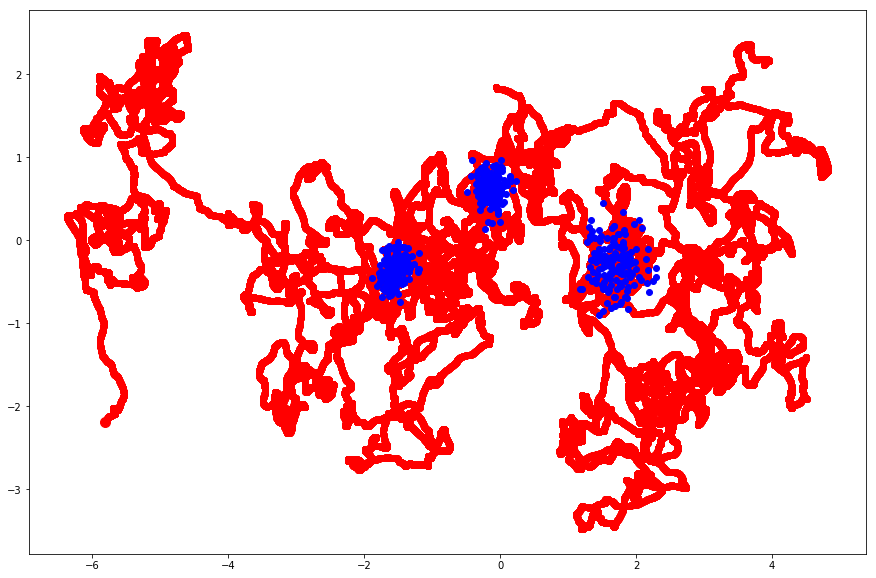

In [115]:
flat_samples = flatten(samples)
plt.figure(figsize=(15, 10))
x_r, x_f = pca(x, flat_samples)
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

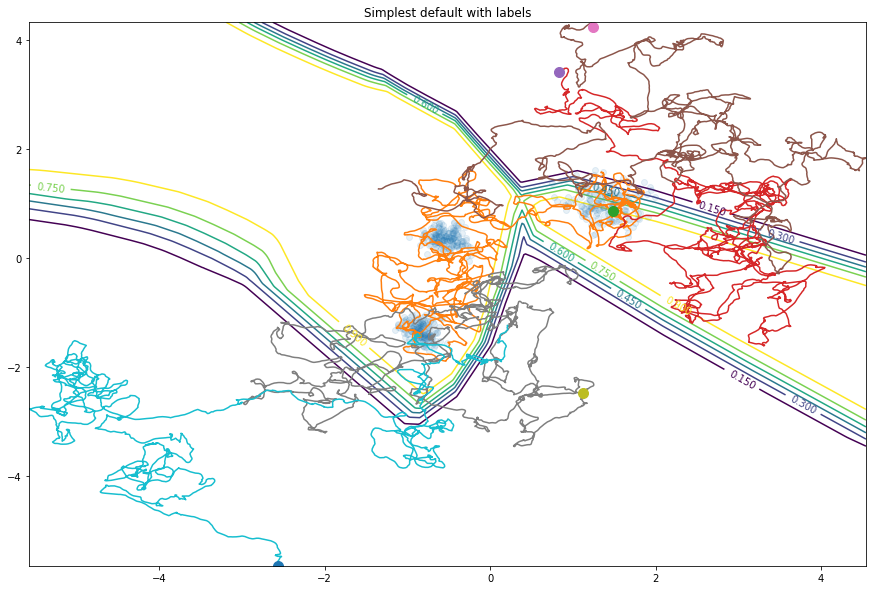

In [116]:
visualize(samples)

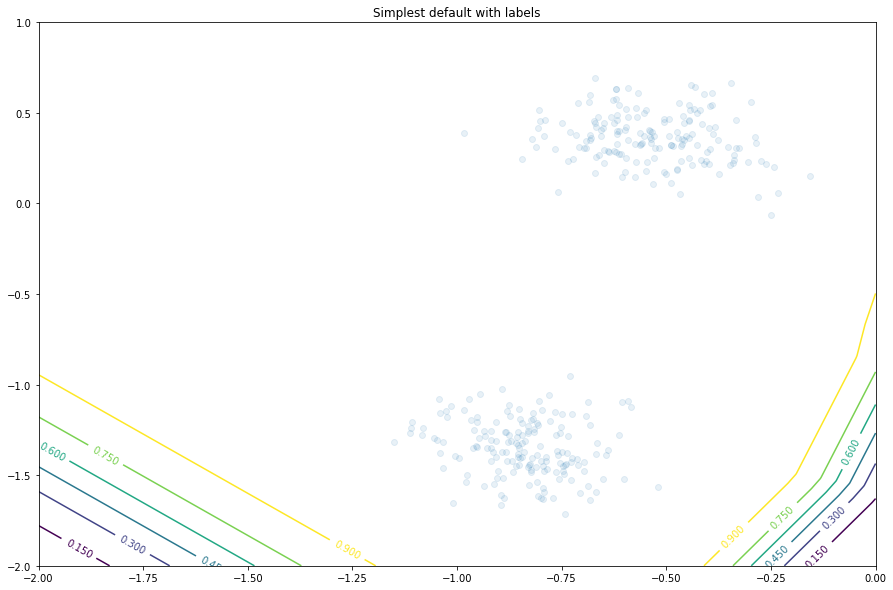

In [120]:
visualize(samples, x_min=-2., x_max=0., y_min=-2, y_max=1., with_samples=False)

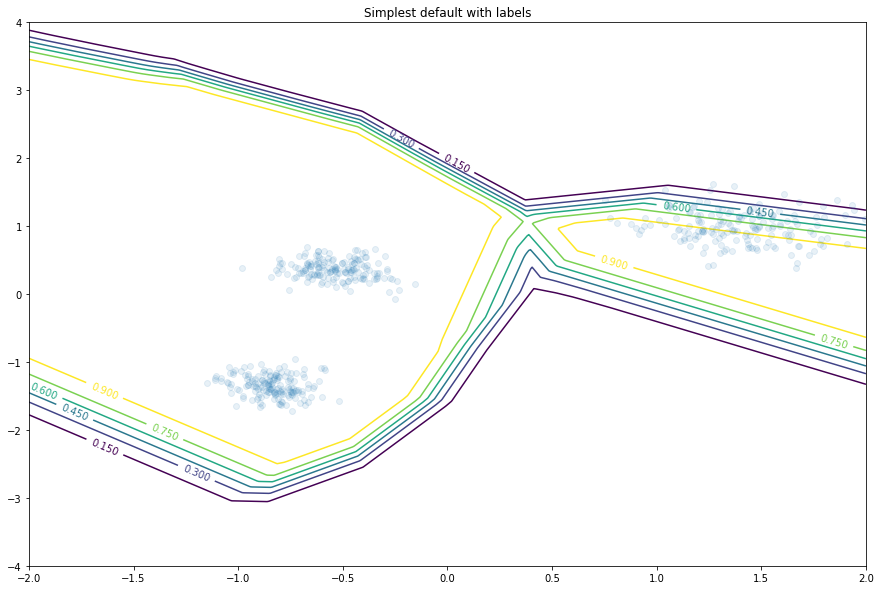

In [121]:
visualize(samples, x_min=-2, x_max=2, y_min=-4, y_max=4, with_samples=False)

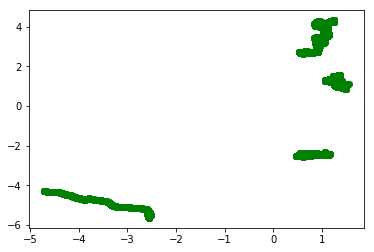

In [119]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)
plt.plot(fake_samples[:, 0], fake_samples[:, 1], 'go')

In [148]:
def thinning(sample_arr, freq=100):
    new_sample_arr = []
    for i, sample in enumerate(sample_arr):
        if not i % freq:
            new_sample_arr.append(sample)
    return np.array(new_sample_arr)

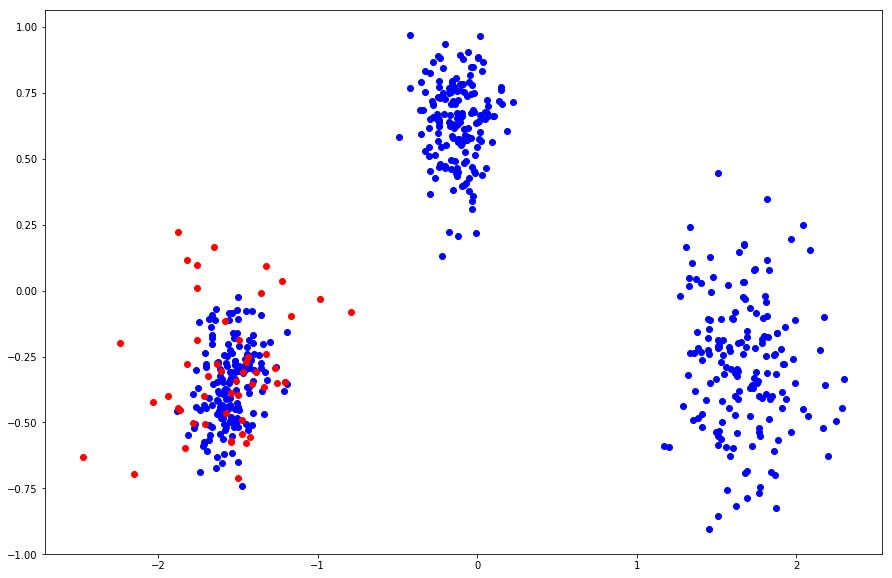

In [149]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, freq=100)[-50:]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

## Now let's try it on a high-dimensional problem

In [150]:
x_dim = 10
data = SynthDataset(x_dim=x_dim, N=5000, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

In [151]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [153]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(x_dim, 1)
disc = DiscriminatorNetwork(x_dim, 2, 200)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, prior, disc, alpha=.1, eta=1e-6, num_data=len(data), disc_lr=1e-4)
samples = []

In [219]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(10000):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        samples.append(np.copy(gen.z_v.data.numpy()))
        bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%10:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
samples = np.vstack(samples)

0
0.0903063
0.137904
10
0.0900126
0.101743
20
0.10278
0.100548
30
0.0754012
0.108892
40
0.0856073
0.0568031
50
0.112409
0.0839944
60
0.0811567
0.0725932
70
0.091675
0.122571
80
0.0616371
0.0505851
90
0.0702903
0.0943984
100
0.0681408
0.0688327
110
0.0676216
0.0501004
120
0.051365
0.06011
130
0.0708496
0.134775
140
0.0654914
0.0614118
150
0.0547449
0.0762759
160
0.053155
0.0508325
170
0.0470649
0.0554027
180
0.0698129
0.0440951
190
0.0389476
0.0806519
200
0.0480584
0.0592287
210
0.03909
0.0446677
220
0.0556151
0.0296305
230
0.0349502
0.0580656
240
0.0550289
0.0752427
250
0.0650056
0.136087
260
0.0666249
0.0650673
270
0.0552159
0.0971456
280
0.0567451
0.0844151
290
0.0448624
0.122235
300
0.0642277
0.104345
310
0.0526613
0.0900751
320
0.0755211
0.109991
330
0.096027
0.0825289
340
0.0644479
0.107588
350
0.0739962
0.0903995
360
0.0890821
0.0703646
370
0.0761781
0.0857074
380
0.0722845
0.0773191
390
0.101275
0.0769572
400
0.0650666
0.138311
410
0.0682642
0.127241
420
0.0728616
0.0744386
430


3380
0.0464143
0.0952607
3390
0.0821509
0.0312014
3400
0.042244
0.0494329
3410
0.0683065
0.0487581
3420
0.0466456
0.0248079
3430
0.0530771
0.0379494
3440
0.0422408
0.0199933
3450
0.0361298
0.0158647
3460
0.0312325
0.0123667
3470
0.0170219
0.011979
3480
0.0320273
0.0499872
3490
0.0160672
0.0418787
3500
0.0134242
0.0137586
3510
0.0105553
0.0410908
3520
0.0145958
0.0367223
3530
0.0141058
0.0170483
3540
0.0130294
0.0470904
3550
0.0145519
0.00932311
3560
0.0203045
0.0237948
3570
0.0275465
0.0201601
3580
0.0318069
0.0509217
3590
0.0268573
0.073402
3600
0.0189421
0.0443848
3610
0.0366437
0.0643873
3620
0.0433144
0.10346
3630
0.046684
0.108165
3640
0.0433477
0.0635356
3650
0.0451741
0.0636151
3660
0.0542163
0.0749771
3670
0.0349089
0.064848
3680
0.0420496
0.0860365
3690
0.050331
0.0538096
3700
0.0580573
0.0631233
3710
0.052634
0.0428397
3720
0.0530438
0.0833775
3730
0.048907
0.0441691
3740
0.0659393
0.0476235
3750
0.0678982
0.0452236
3760
0.0593554
0.0425433
3770
0.0501535
0.0968801
3780
0.079

6680
0.0776015
0.0607826
6690
0.0875957
0.1023
6700
0.0583761
0.0840549
6710
0.0755725
0.076115
6720
0.0888984
0.0353551
6730
0.0619978
0.132137
6740
0.0761857
0.0438829
6750
0.0794876
0.0770679
6760
0.0975932
0.0909404
6770
0.0706352
0.074338
6780
0.056788
0.0365586
6790
0.056175
0.0317542
6800
0.0458273
0.0733059
6810
0.0370645
0.0518865
6820
0.0454252
0.107268
6830
0.0442815
0.0535307
6840
0.0901618
0.0751101
6850
0.0882678
0.102265
6860
0.0764156
0.0708078
6870
0.0578076
0.106428
6880
0.0636993
0.0841371
6890
0.0791564
0.0752076
6900
0.0566085
0.0850938
6910
0.0818591
0.0982929
6920
0.0756677
0.0985187
6930
0.0680051
0.0821587
6940
0.0505181
0.0543133
6950
0.0353505
0.0343868
6960
0.0254106
0.0872671
6970
0.0523977
0.0981119
6980
0.0424576
0.0532336
6990
0.0547863
0.0795664
7000
0.0779963
0.157938
7010
0.073857
0.0702478
7020
0.0810931
0.0815609
7030
0.113509
0.113878
7040
0.0930702
0.145389
7050
0.107763
0.102643
7060
0.101371
0.104151
7070
0.0992007
0.0483025
7080
0.0557473
0.076

In [220]:
samples.shape

(2300000, 10)

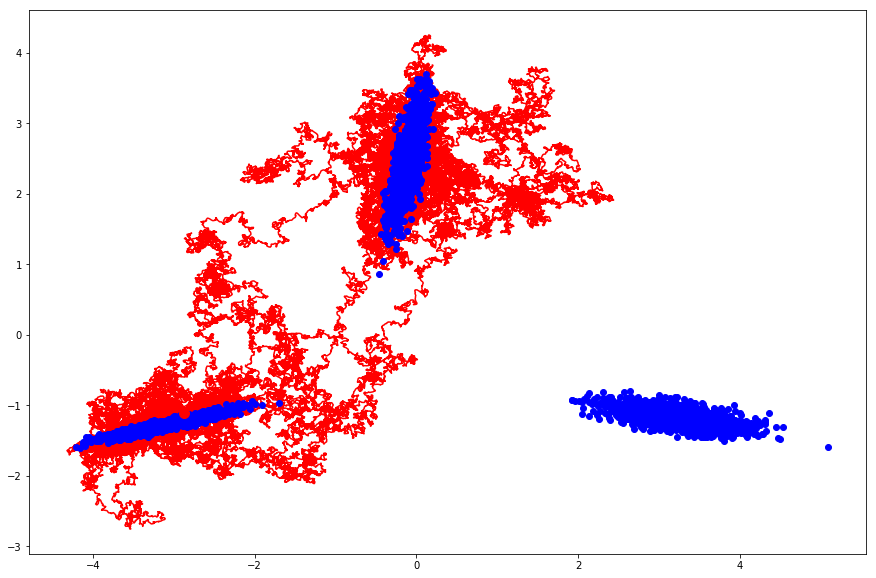

In [230]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), samples)
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

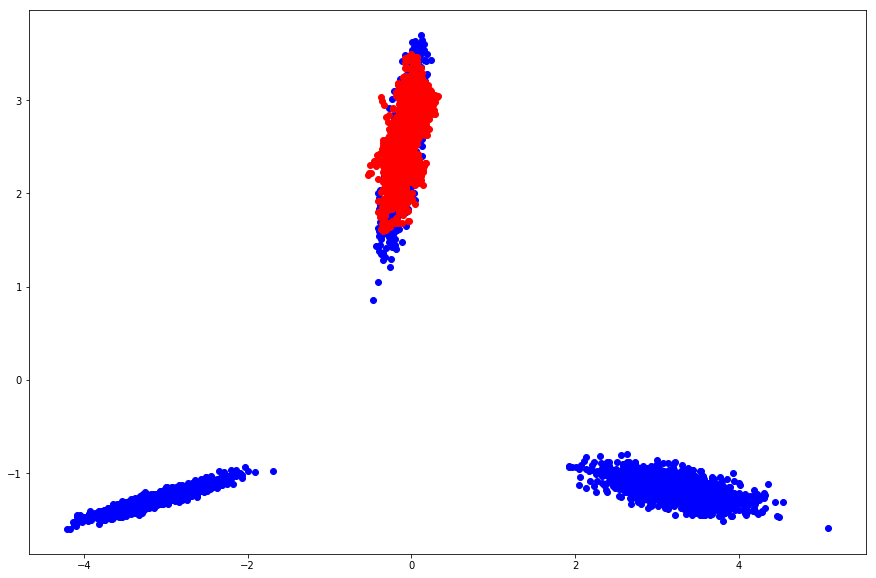

In [229]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, 100)[11000:13000]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

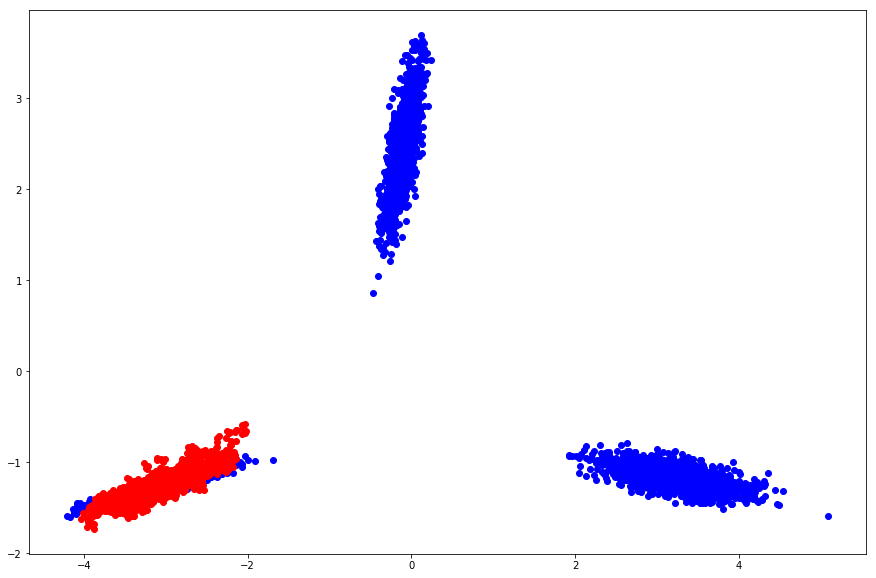

In [228]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, 100)[-2000:]#-10000]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

In [239]:
np.max(disc(Variable(torch.from_numpy(samples[-50000:]).float()))[:, 0].data.numpy())

0.84902722

In [259]:
sample_probs = disc(Variable(torch.from_numpy(samples).float()))[:, 0].data.numpy()

In [260]:
sample_probs.shape

(2300000,)

In [265]:
idx = np.where(sample_probs > 0.7)
good_samples = samples[idx]

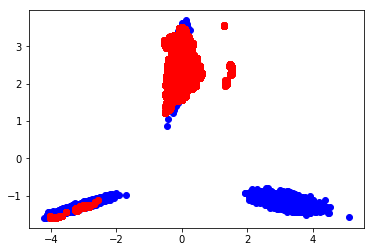

In [266]:
x_r, x_f = pca(data.X.numpy(), good_samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
# plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

In [269]:
true_probs = disc(Variable(data.X))[:, 0].data.numpy()
np.min(true_probs)

0.37969503

In [270]:
bad_idx = np.where(true_probs < 0.7)
bad_data = data.X.numpy()[bad_idx]

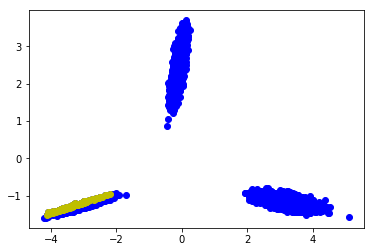

In [271]:
x_r, x_b = pca(data.X.numpy(), bad_data)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_b[:, 0], x_b[:, 1], 'yo')